In [1]:
# read files /home/s94zalek/Diff-FMAPs-PyTorch/data/12k_shapes_train.npy
import numpy as np

# load data
shapes_train = np.load('/home/s94zalek/Diff-FMAPs-PyTorch/data/12k_shapes_train.npy', allow_pickle=True)
shapes_test = np.load('/home/s94zalek/Diff-FMAPs-PyTorch/data/12k_shapes_test.npy', allow_pickle=True)

# read /home/s94zalek/Diff-FMAPs-PyTorch/data/12ktemplate.ply

import trimesh
template = trimesh.load('/home/s94zalek/Diff-FMAPs-PyTorch/data/12ktemplate.ply')

# read /home/s94zalek/Diff-FMAPs-PyTorch/data/FAUST_noise_0.01.mat
import scipy.io
faust_noise = scipy.io.loadmat('/home/s94zalek/Diff-FMAPs-PyTorch/data/FAUST_noise_0.01.mat')

# Template shape

In [71]:
import torch
import trimesh
import numpy as np

scene = trimesh.Scene()
# scene.add_geometry(template)
# scene.show()

# Train dataset

In [14]:
# import datasets_code.surreal_dataset as sd
# dataset = sd.SingleSurrealDataset(phase='train', num_evecs=200)

from datasets_code.surreal_full import SingleSurrealDataset

dataset = SingleSurrealDataset(
    n_body_types_male=15, n_body_types_female=15, n_poses_straight=25, n_poses_bent=5,
    num_evecs=50
    )

Generating female shapes: 100%|████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.44it/s]


In [ ]:
from tqdm import tqdm

scene.geometry.clear()

for i in tqdm(range(5)):
    scene.add_geometry(trimesh.Trimesh(
        vertices=dataset[i]['second']['verts'] + np.array([i, 0, 0]),
        faces=dataset[i]['second']['faces']
        ))
    
# add coordinate axis
scene.add_geometry(trimesh.creation.axis(axis_length=0.5))
scene.show()

In [72]:
# plot the first shape as point cloud

def points_to_spheres(points, radius=1):
    """
    Convert points into spheres for notebook-friendly display
    """
    return [
        trimesh.primitives.Sphere(radius=radius, center=pt) for pt in points
    ]
    
def plot_lb_evecs(scene, data, evec_idx, offset):
    mesh = trimesh.Trimesh(vertices=data['verts'] + np.array([offset, 0, 0]), faces=data['faces'])
    
    # L, M = robust_laplacian.mesh_laplacian(data['verts'].numpy(), data['faces'].numpy())

    # # Compute some eigenvectors
    # n_eig = 50
    # evals, evecs = sla.eigsh(L, n_eig, M, sigma=1e-8) 
    
    evecs = data['evecs'] 
    
    cmap = trimesh.visual.color.interpolate(evecs[:, evec_idx], 'bwr')
    mesh.visual.vertex_colors = cmap
    
    scene.add_geometry(mesh)


scene.geometry.clear()

evec_idx = 20

data_0 = dataset[2]
data_1 = dataset[324]
data_2 = dataset[436]

plot_lb_evecs(scene,
              data_0['first'],
              evec_idx = evec_idx,
              offset = 0)
plot_lb_evecs(scene,
              data_0['second'],
              evec_idx = evec_idx,
              offset = 1)
plot_lb_evecs(scene,
              data_1['second'],
              evec_idx = evec_idx,
              offset = 2)
plot_lb_evecs(scene,
                data_2['second'],
                evec_idx = evec_idx,
                offset = 3)
scene.show()

# Check for intrinsic correspondence

In [ ]:
scene.geometry.clear()

# cmap = trimesh.visual.color.interpolate(np.linspace(0, 1, len(data_y['verts'][0])), 'jet')

data_x = shapes_train[10]
data_y = shapes_train[107]

# make a color map based on y coordinate
cmap = trimesh.visual.color.interpolate(template.vertices[:, 1], 'jet')


# add the first mesh
mesh1 = trimesh.Trimesh(vertices=data_x, faces=template.faces)
mesh1.visual.vertex_colors = cmap
scene.add_geometry(mesh1)

mesh2 = trimesh.Trimesh(vertices=data_y + np.array([1, 0, 0]), faces=template.faces)
mesh2.visual.vertex_colors = cmap[:len(mesh2.vertices)]
scene.add_geometry(mesh2)


# display the scene
scene.show('notebook')

# Study functional maps

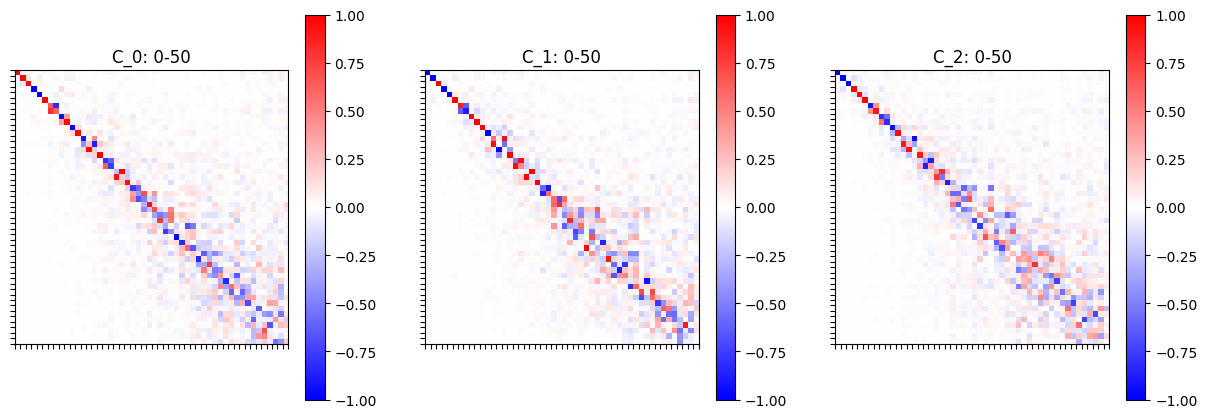

In [73]:
import matplotlib.pyplot as plt
import numpy as np

def plot_Cxy(figure, axis, Cxy_plt, title, min_dim, max_dim):
    
    axis_plot = axis.imshow(Cxy_plt[min_dim:max_dim, min_dim:max_dim], cmap='bwr', vmin=-1, vmax=1)
    figure.colorbar(axis_plot, ax=axis)
    
    axis.set_title(f'{title}: {min_dim}-{max_dim}')

    axis.set_xticks(np.arange(-0.5, max_dim - min_dim, 1.0))
    axis.set_yticks(np.arange(-0.5, max_dim - min_dim, 1.0))     
    # axis.grid(which='both')
    
    axis.set_xticklabels([])
    axis.set_yticklabels([])
   

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_Cxy(fig, ax[0], data_0['C_gt_xy'], 'C_0', 0, 50)
plot_Cxy(fig, ax[1], data_1['C_gt_xy'], 'C_1', 0, 50)
plot_Cxy(fig, ax[2], data_2['C_gt_xy'], 'C_2', 0, 50)

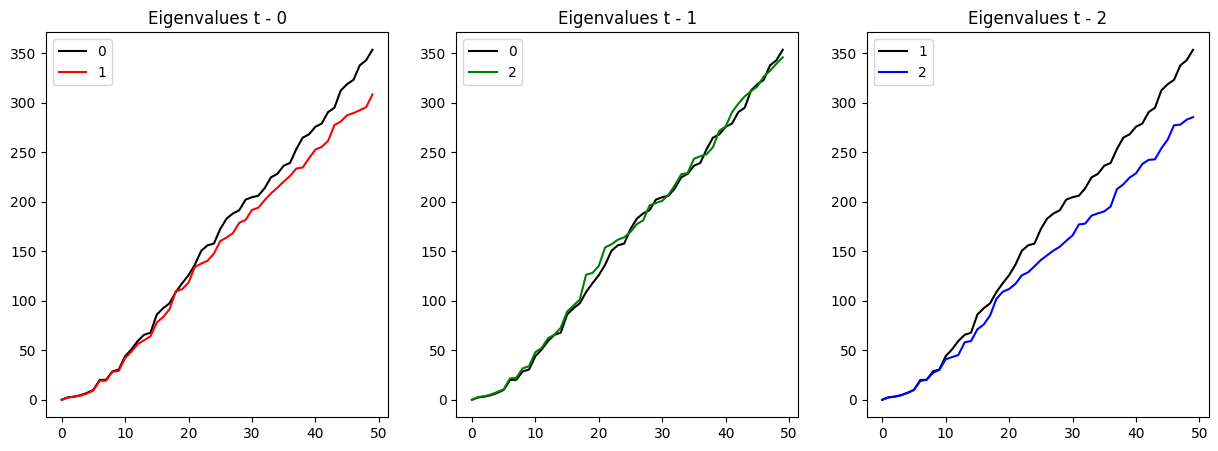

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

min_idx = 0
max_idx = 200

ax[0].plot(data_0['first']['evals'][min_idx:max_idx], '-', label='0', color='black')
ax[0].plot(data_0['second']['evals'][min_idx:max_idx], '-', label='1', color='red')
# ax[0].set_yscale('log')
ax[0].set_title('Eigenvalues t - 0')
ax[0].legend()

ax[1].plot(data_0['first']['evals'][min_idx:max_idx], '-', label='0', color='black')
ax[1].plot(data_1['second']['evals'][min_idx:max_idx], '-', label='2', color='green')
# ax[1].set_yscale('log')
ax[1].set_title('Eigenvalues t - 1')
ax[1].legend()

ax[2].plot(data_0['first']['evals'][min_idx:max_idx], '-', label='1', color='black')
ax[2].plot(data_2['second']['evals'][min_idx:max_idx], '-', label='2', color='blue')
# ax[2].set_yscale('log')
ax[2].set_title('Eigenvalues t - 2')
ax[2].legend()

plt.show()

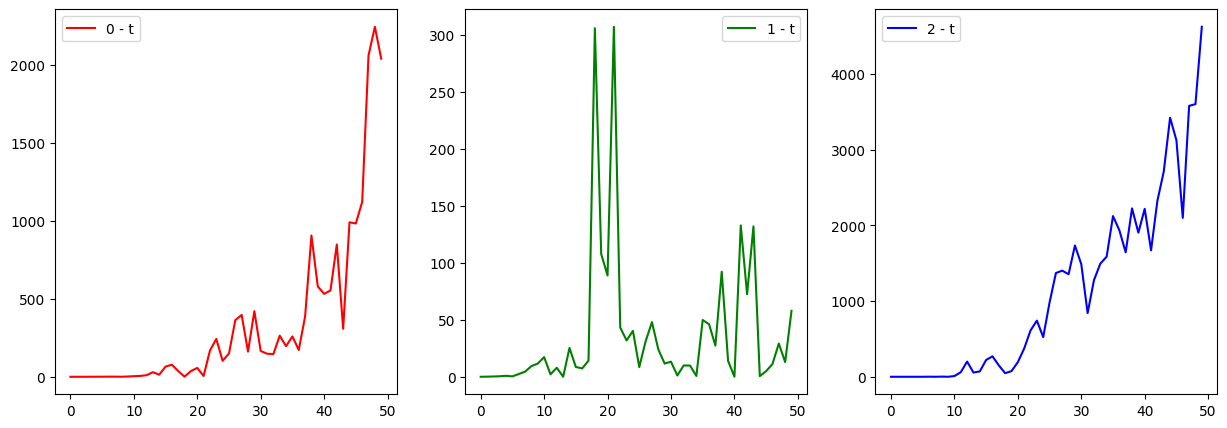

In [12]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(
    (data_0['second']['evals'][min_idx:max_idx] - data_0['first']['evals'][min_idx:max_idx])**2,
    '-', label='0 - t', color='red', )
ax[0].legend()

ax[1].plot(
    (data_1['second']['evals'][min_idx:max_idx] - data_0['first']['evals'][min_idx:max_idx])**2,
    '-', label='1 - t', color='green')
ax[1].legend()

ax[2].plot(
    (data_2['second']['evals'][min_idx:max_idx] - data_0['first']['evals'][min_idx:max_idx])**2,
    '-', label='2 - t', color='blue')
ax[2].legend()


plt.show()

In [26]:
from tqdm import tqdm

eigenvalues = []
fmaps = []

for i in tqdm(range(len(dataset))):
    data = dataset[i]
    eigenvalues.append(data['second']['evals'])
    
    fmap = data['C_gt_xy']
    fmaps.append(fmap)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [10:38<00:00,  1.41it/s]


In [28]:
eigenvalues_np = np.stack(eigenvalues)
fmaps_np = np.stack(fmaps)

eigenvalues_np.shape, fmaps_np.shape

((900, 50), (900, 50, 50))

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=10)
tsne = TSNE(n_components=2)
scaler = StandardScaler()

evals_scaled = scaler.fit_transform(eigenvalues_np[:, :])
pca_evals = pca.fit_transform(evals_scaled)
tsne_evals = tsne.fit_transform(pca_evals)


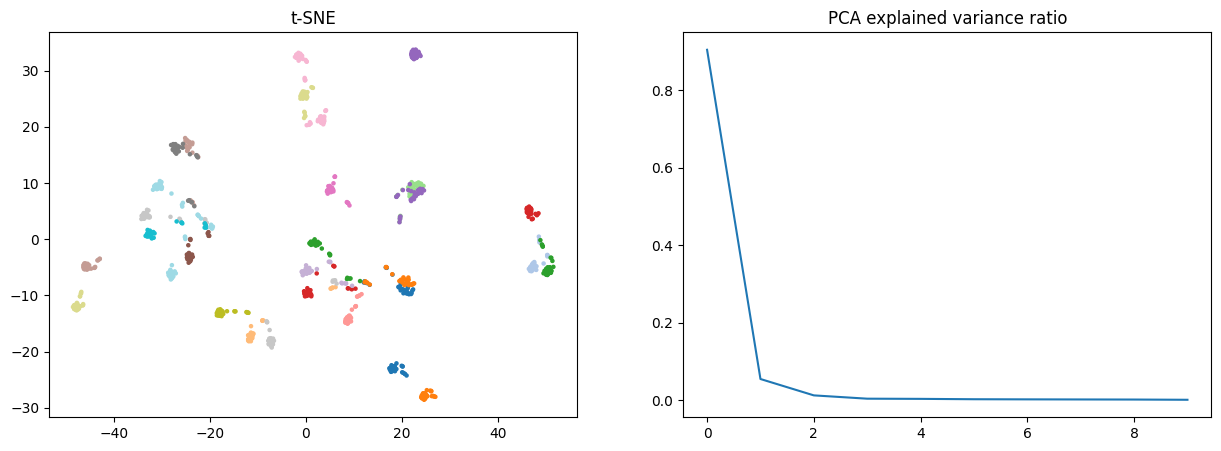

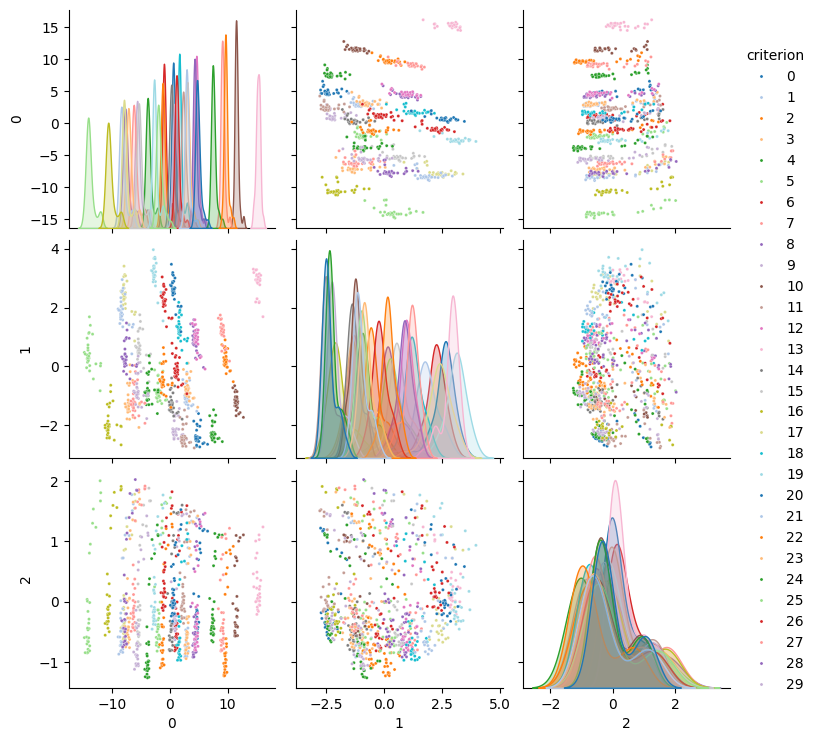

In [46]:
import seaborn as sns
import pandas as pd

body_types = [i // 30 for i in range(len(dataset))]
poses = [i % 30 for i in range(len(dataset))]

criterion = body_types

point_size = 5

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(tsne_evals[:, 0], tsne_evals[:, 1], c=criterion, cmap='tab20', s=point_size)
ax[0].set_title('t-SNE')

variance_ratio = pca.explained_variance_ratio_
ax[1].plot(variance_ratio)
ax[1].set_title('PCA explained variance ratio')


pca_df = pd.DataFrame(pca_evals[:1000, :3])
pca_df['criterion'] = criterion[:1000]

sns.pairplot(pca_df,
             diag_kind='kde', plot_kws={'s': point_size},
             hue='criterion', palette='tab20')



In [66]:
fmaps_scaled = scaler.fit_transform(np.abs(fmaps_np[:, :, :]).reshape(len(fmaps_np), -1))
# fmaps_scaled = scaler.fit_transform(
#     np.matmul(fmaps_np[:, :30, :30].transpose(0, 2, 1), fmaps_np[:, :30, :30]).reshape(len(fmaps_np), -1)
#     )
pca_fmaps = pca.fit_transform(fmaps_scaled)
tsne_fmaps = tsne.fit_transform(pca_fmaps)

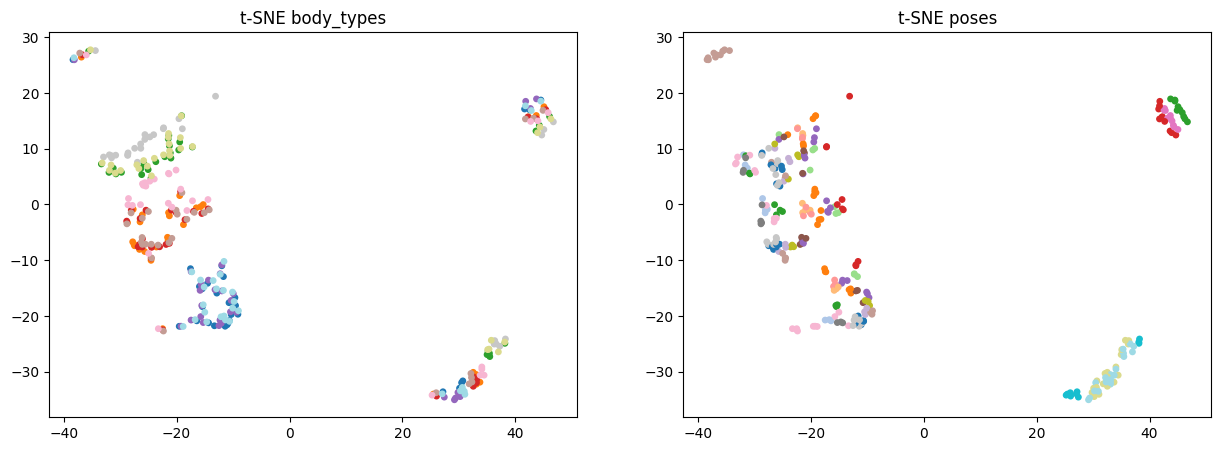

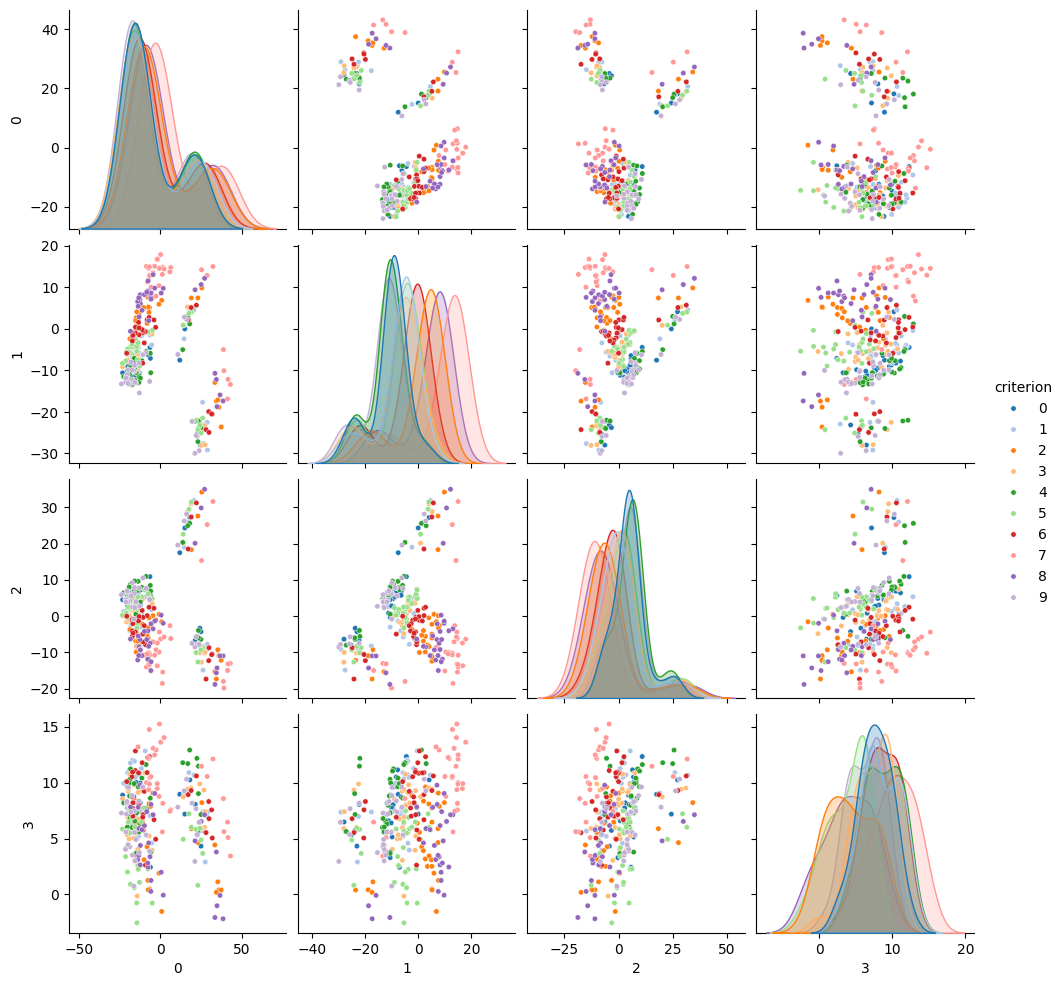

In [70]:
import seaborn as sns
import pandas as pd

max_points = 300

body_types = [i // 30 for i in range(len(dataset))]
poses = [i % 30 for i in range(len(dataset))]
gender = [i // (30*15) for i in range(len(dataset))]

criterion = body_types[:max_points]

point_size = 15

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(tsne_fmaps[:max_points, 0], tsne_fmaps[:max_points, 1],
              c=body_types[:max_points], cmap='tab20', s=point_size)
ax[0].set_title('t-SNE body_types')

ax[1].scatter(tsne_fmaps[:max_points, 0], tsne_fmaps[:max_points, 1],
              c=poses[:max_points], cmap='tab20', s=point_size)
ax[1].set_title('t-SNE poses')

pca_df = pd.DataFrame(pca_fmaps[:max_points, :4])
pca_df['criterion'] = criterion[:max_points]

sns.pairplot(pca_df,
             diag_kind='kde', plot_kws={'s': point_size},
             hue='criterion', palette='tab20')



In [85]:
ev_file = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/eigenvalues/train/eigenvalues.txt')
fmap_file = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/functional_maps/train/functional_maps.txt')
ev_file.shape, fmap_file.shape

((3340, 50), (3340, 2500))

In [ ]:
fmap_file[0].reshape(50, 50)

In [83]:
np.abs(fmaps_np[0] - fmap_file[0].flatten().reshape(50, 50)).sum()

126.41845716367064